In [1]:
import ccdproc, sys,glob,yaml, shutil
from pathlib import Path
from astropy.nddata import CCDData
#sys.path.insert(1, '/Users/kirstencasey/projects/LBCreduce/lbcred')
#import image, reduce, 
import time, os, warnings
from astropy import stats
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.utils.exceptions import AstropyUserWarning

In [2]:
#### Call function to get images
lbc_raw = Path('/Users/kirstencasey/test_raw_ims/')
#lbc_raw = Path('/Volumes/WD-EXFAT/Images/lbc-raw/')

#lbc_red = Path('/Volumes/WD-EXFAT/Images/','lbc-reduced')
#lbc_red.mkdir(exist_ok=True)
keys = ['imagetyp', 'filter', 'object']
all_files = ccdproc.ImageFileCollection(lbc_raw, keywords=keys)
print(all_files.summary)

           file           imagetyp   filter   object
------------------------- -------- --------- -------
lbcb.20191220.003943.fits     flat SDT_Uspec SkyFlat
lbcb.20191220.004029.fits     flat SDT_Uspec SkyFlat
lbcb.20191220.004110.fits     flat SDT_Uspec SkyFlat
lbcb.20191220.004155.fits     flat SDT_Uspec SkyFlat
lbcb.20191220.004237.fits     flat SDT_Uspec SkyFlat
lbcb.20191220.004615.fits     flat  B-BESSEL SkyFlat
lbcb.20191220.004658.fits     flat  B-BESSEL SkyFlat
lbcb.20191220.004744.fits     flat  B-BESSEL SkyFlat
lbcb.20191220.004910.fits     flat  B-BESSEL SkyFlat
lbcb.20191220.005038.fits     flat  V-BESSEL SkyFlat
                      ...      ...       ...     ...
lbcr.20191222.052427.fits   object  R-BESSEL    KK17
lbcr.20191222.052542.fits   object  R-BESSEL    KK17
lbcr.20191222.053122.fits   object  R-BESSEL    KK17
lbcr.20191222.053239.fits   object  R-BESSEL    KK17
lbcr.20191222.053819.fits   object  R-BESSEL    KK17
lbcr.20191222.053944.fits   object  R-BESSEL  

In [11]:
# NEW #
def initialize_config(config_filename):
	# Open and read config file
	with open(config_filename, 'r') as filename:
		config = yaml.load(filename, Loader=yaml.FullLoader)

	return config

def get_image_info(config, image_dir=None, filenames=None):

	if image_dir is None:
		image_dir = config['image_dir']

	if filenames is None:
		all_images = glob.glob(image_dir+config['glob_include'])

		if len(all_images) == 0:
			warnings.warn('No files found in image_dir!', AstropyUserWarning)	########## WORK ON THIS - for when no files are found ###########
			sys.exit('lbcreduce stopped.')

		if config['exclude'] is not None:
			all_images = [ im for im in all_images if config['exclude'] not in im ]

	else:
		all_images = filenames
	all_images = [im.split('/')[-1] for im in all_images]

	# Loop through files to get relevant information
	propids = []
	objects = []
	imagetyps = []					######################### DO THIS BETTER!!!!!########################
	filters = []
	lbcinst = []
	for fi in all_images:
		hdulist = fits.open(image_dir + fi)
		propids.append(hdulist[0].header['PROPID'])
		objects.append(hdulist[1].header['OBJECT'])
		imagetyps.append(hdulist[1].header['IMAGETYP'])
		filters.append(hdulist[1].header['FILTER'])
		lbcinst.append(hdulist[0].header['INSTRUME'])
		hdulist.close()

	propids = np.asarray(propids)
	all_images = np.asarray(all_images)
	objects = np.asarray(objects)
	imagetyps = np.asarray(imagetyps)
	filters = np.asarray(filters)
	lbcinst = np.asarray(lbcinst)
	'''																########### THIS DOESN'T WORK!!!! NEED TO NOT EXCLUDE FLATS, BIAS IMAGES, ETC.
	if config['propid'] is not None:
		ims_to_keep = np.where(propids==config['propid'])
		propids = propids[ims_to_keep]
		all_images = all_images[ims_to_keep]
		objects = objects[ims_to_keep]
		imagetyps = imagetyps[ims_to_keep]

	if config['object'] is not None:
		ims_to_keep = np.where(objects==config['object'])
		propids = propids[ims_to_keep]
		all_images = all_images[ims_to_keep]
		objects = objects[ims_to_keep]
		imagetyps = imagetyps[ims_to_keep]
	'''
	image_info = Table()
	image_info['filename'] = all_images
	image_info['imagetyp'] = imagetyps
	image_info['object'] = objects
	image_info['propid'] = propids
	image_info['filter'] = filters
	image_info['instrument'] = lbcinst

	return image_info

In [10]:
# OLD #
def initialize_config(config_filename):
	# Open and read config file
	with open(config_filename, 'r') as filename:
		config = yaml.load(filename, Loader=yaml.FullLoader)

	return config

def get_image_info(config, image_dir=None):
	if image_dir is None:
		image_dir = config['image_dir']

	# all_images = ImageFileCollection(image_dir, ext=config['ext'], keywords=keys, **config['file_selection_options'])
	all_images = glob.glob(image_dir+config['glob_include'])

	if len(all_images) == 0:
		warnings.warn('No files found in image_dir!', AstropyUserWarning)	########## WORK ON THIS - for when no files are found ###########
		sys.exit('lbcreduce stopped.')

	if config['exclude'] is not None:
		all_images = [ im for im in all_images if config['exclude'] not in im ]

	# Loop through files to get relevant information
	propids = []
	objects = []
	imagetyps = []

	for fi in all_images:
		hdulist = fits.open(fi)
		propids.append(hdulist[0].header['PROPID'])
		objects.append(hdulist[0].header['OBJECT'])
		imagetyps.append(hdulist[0].header['IMAGETYP'])

		hdulist.close()

	propids = np.asarray(propids)
	all_images = np.asarray(all_images)
	objects = np.asarray(objects)
	imagetyps = np.asarray(imagetyps)

	'''########### THIS DOESN'T WORK!!!! NEED TO NOT EXCLUDE FLATS, BIAS IMAGES, ETC.
	if config['propid'] is not None:
		ims_to_keep = np.where(propids==config['propid'])
		propids = propids[ims_to_keep]
		all_images = all_images[ims_to_keep]
		objects = objects[ims_to_keep]
		imagetyps = imagetyps[ims_to_keep]

	if config['object'] is not None:
		ims_to_keep = np.where(objects==config['object'])
		propids = propids[ims_to_keep]
		all_images = all_images[ims_to_keep]
		objects = objects[ims_to_keep]
		imagetyps = imagetyps[ims_to_keep]
	'''
	image_info = Table()
	image_info['filename'] = all_images
	image_info['imagetyp'] = imagetyps
	image_info['object'] = objects
	image_info['propid'] = propids


	return image_info

In [12]:
config = initialize_config('../lbcred/lbcreduce-config.yml')

file_info = get_image_info(config,'/Users/kirstencasey/test_raw_ims/')
#file_info = get_image_info(config,'/Volumes/WD-EXFAT/Images/lbc-raw/')
#mid_info = get_image_info(config,'/Users/kirstencasey/projects/LBCreduce/lbcred/test_out/midproc/')

In [13]:
combine_arg_dict = {'masked median': np.ma.median}
config = dict(sigma_clip_func='masked median',sigma_clip=True,num=5)
config['sigma_clip_func'] = combine_arg_dict[config['sigma_clip_func']]
config['sigma_clip_func']


<function numpy.ma.extras.median(a, axis=None, out=None, overwrite_input=False, keepdims=False)>

In [11]:
counts = []
for fi in file_info['filename']:
    data = CCDData.read(fi, unit=config['data_units'], hdu=config['ext'])
    data_sum = np.sum(data)
    counts.append(data_sum)
    
print(counts)
plt.hist(counts,bins=40)

[2907166008, 2920501560, 17840030310, 190166925212, 285562142522, 156281184714, 4184352692, 239267115727, 11102815085, 85143852958, 2717473027, 2737348021]


In [56]:
file_info

data = CCDData.read(file_info[2]['filename'],unit='adu',ext=1)
print(file_info[2]['filename'],file_info[5]['filename'])
#flat = CCDData.read(file_info[5]['filename'],unit='adu',ext=1)

result = CCDData.divide(data, flat)

INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]
/Users/kirstencasey/test_out/midproc/lbcr.20191220.140043-chip1_T.fits /Users/kirstencasey/test_out/midproc/masterflat-chip1_B-BESSEL.fits


In [55]:
flat.data[np.where(flat.data==0)]='Nan'

In [61]:
CCDData.write(result,'test.fits',format='fits')

IORegistryError: No writer defined for format 'fits' and class 'NoneType'.

The available formats are:

Format Read Write Auto-identify
------ ---- ----- -------------

In [79]:
type(result.meta)
hdr = fits.Header(data.meta)

fits.writeto('out.fits', result.data, hdr,overwrite=True)

In [49]:
file_info#[np.where(file_info['imagetyp']=='object')]

filename,imagetyp,object,propid
str58,str6,str13,str13
/Volumes/WD-EXFAT/Images/lbc-raw/lbcr.20191221.063655.fits,object,I2574,OSU_monitor
/Volumes/WD-EXFAT/Images/lbc-raw/lbcr.20191221.064033.fits,object,I2574,OSU_monitor
/Volumes/WD-EXFAT/Images/lbc-raw/lbcr.20191221.064413.fits,object,I2574,OSU_monitor
/Volumes/WD-EXFAT/Images/lbc-raw/lbcr.20191221.070144.fits,object,N925,OSU_monitor
/Volumes/WD-EXFAT/Images/lbc-raw/lbcr.20191221.070725.fits,object,N925,OSU_monitor
/Volumes/WD-EXFAT/Images/lbc-raw/lbcb.20191220.003943.fits,flat,SkyFlat,flatcalib
/Volumes/WD-EXFAT/Images/lbc-raw/lbcr.20191221.071305.fits,object,N925,OSU_monitor
/Volumes/WD-EXFAT/Images/lbc-raw/lbcr.20191221.071846.fits,object,N925,OSU_monitor
/Volumes/WD-EXFAT/Images/lbc-raw/lbcb.20191220.004029.fits,flat,SkyFlat,flatcalib


In [33]:
#print(all_files.summary)
biases = all_files.files_filtered(imagetyp='zero')
print(biases)
'''
for ccd, filename in biases.ccds(imagetyp='zero',unit='adu',return_fname=True):
    #ccd = ccdproc.subtract_overscan(ccd, overscan=ccd[:, 2055:], median=True)
    print('hi')
    # Trim the overscan
    #ccd = ccdproc.trim_image(ccd[:, :2099])
    
    # Save the result
    #ccd.write('/Users/casey.395/projects/LBCreduce/lbcred/test_out/midproc/testbias_T.fits')
''';

['lbcb.20191220.140452.fits']


In [41]:
data = CCDData.read('/Users/casey.395/projects/LBCreduce/lbcred/test_raw_ims/lbcb.20191220.140452.fits',unit='adu')
data_o = ccdproc.subtract_overscan(data, overscan=data[:, 2098:], median=True)
data_ot = ccdproc.trim_image(data_o[:, :2099])

INFO:astropy:first HDU with data is extension 1.


INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]


In [52]:
section = data.meta['BIASSEC']
print(section)
xmin = int(section.split('[')[1].split(':')[0])
xmax = int(section.split(':')[1].split(',')[0])
ymin = int(section.split(',')[1].split(':')[0])
ymax = int(section.split(':')[-1].split(']')[0])
print(xmin,xmax,ymin,ymax)

[2099:2304,1:4608]
2099 2304 1 4608


In [53]:
section.split(':')

['[2099', '2304,1', '4608]']

In [22]:
#keys = ['imagetyp','object','filter','propid']
#collection = ccdproc.ImageFileCollection(lbc_raw, keywords=keys, ext=1)
#sub_collection = collection.files_filtered(imagetyp='object',filter='B-BESSEL',object='*')
all_files.values('imagetyp',unique=True)

['zero', 'FOCUS', 'object', 'flat']

In [1]:
print(collection.summary)

NameError: name 'collection' is not defined

In [21]:
imtype='*'
objectname='M81blob'
filt='*'

images = collection.filter(imagetyp=imtype, object=objectname, filter=filt)
options = {}
options['imtype'] = images.values('imagetyp', unique=True)
options['objectname'] = images.values('object', unique=True)
options['filt'] = images.values('filter', unique=True)
print('Options','-------',sep='\n')
print('\n','imtype: ', options['imtype'],sep='')
print('\n','objectname: ', options['objectname'], sep='')
print('\n', 'filt: ', options['filt'], sep='')

Options
-------

imtype: ['object']

objectname: ['M81blob']

filt: ['B-BESSEL', 'R-BESSEL']


In [7]:
images = image.get_images('/Volumes/WD-EXFAT/Images/lbc-raw/', objectname='KK17', filt='R-BESSEL');

In [25]:
len(images.summary)

16

In [47]:
means1 = []
for im in images.data():
    mean = stats.sigma_clip(im, sigma=3, maxiters=3).mean()
    means1.append(mean)
    print(im.stddev)

AttributeError: 'numpy.ndarray' object has no attribute 'stddev'

In [45]:
means2 = []
for im in images.data():
    mean = im.mean()
    means2.append(mean)

In [46]:
np.asarray(means1)-np.asarray(means2)

array([1168.52664821,  120.7718156 , 1150.65100414,   96.80109063,
       1166.52538484,  112.80384252, 1188.94975444,  125.10706768,
       1272.26788388,  126.78458644, 1234.15903583,  124.62784779,
       1253.6869325 ,  117.28858983, 1159.0992192 ,  111.17959801])

In [19]:
i=0
for im in images.data():
    if i==0:
        clipped = stats.sigma_clip(im,sigma=5, cenfunc='median', stdfunc=stats.mad_std)
        im0 = im
    i+=1

In [24]:
clipped.std()

278.13776542352724

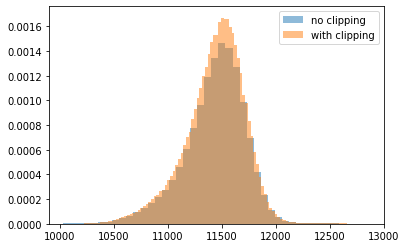

In [38]:
clipped_nonan = clipped[~np.isnan(clipped)]
plt.hist(np.ndarray.flatten(im0),density=True,bins=1000,alpha=0.5,label='no clipping')
plt.hist(np.ndarray.flatten(clipped_nonan),density=True,bins=100,alpha=0.5,label='with clipping')
plt.xlim(9900,13000)
plt.legend()
plt.show()

In [ ]:
def get_images(directory, imtype='*', objectname='*', filt='*', display_options=False):
	'''
	This function returns a list of images given input parameters specifying the type of images needed.

	Parameters
	----------
	directory : str
		The directory in which getImages should look for .fits files.

	imtype : str
		The IMAGETYP keyword in the header of the .fits files to be returned. Used to indicate whether
		the returned images should be flats, biases, objects, etc.

	objectname : str
		The OBJECT keyword in the header of the .fits files to be returned. Used to indicate which
		target (eg. UGC1171, NGC628, etc.) is desired.

	filt : str
		The FILTER keyword in the header of the .fits files to be returned. Used to indicate which
		telescope filter (eg. B-BESSEL, R-BESSEL, etc.) is desired.

	display_options : bool
		If True, get_images will not return a list of images but will instead return a dict of available
		options for each other input parameter (imtype, objectname, redlevel) based on the contents of
		the .fits headers in the given directory.

	Returns
	-------
	ImageFileCollection (when display_options == False)
		Returns an ImageFileCollection object containing information about images consistent with the input parameters

	'''

	path = Path(directory)
	keys = ['imagetyp','object','filter','propid','exptime']
	all_images = ImageFileCollection(path, keywords=keys)

	try:
		images = all_images.filter(imagetyp=imtype, object=objectname, filter=filt)
	except FileNotFoundError:
		print('No images match the given options.')
		return

	if display_options:
		options = {}

		options['imtype'] = images.values('imagetyp', unique=True)
		options['objectname'] = images.values('object', unique=True)
		options['filt'] = images.values('filter', unique=True)

		print('Options','-------',sep='\n')
		print('\n','imtype:', options['imtype'], sep='')
		print('\n', 'objectname:', options['objectname'], sep='')
		print('\n', 'filt:', options['filt'], sep='')

	else:

		images = all_images.filter(imagetyp=imtype, object=objectname, filter=filt)

		return images

In [10]:
image_dir = './'
datetime = time.strftime('%Y-%m-%d_%H:%M:%S',time.gmtime())
out_dir_default = image_dir + f'../lbcreduce_{datetime}'
out_dir_default

'./../lbcreduce_2020-02-19_18:15:47'

In [29]:
os.path.isdir('test')

True

In [32]:
dir_exists = True
overwrite = True

dir_exists and not overwrite

False

In [55]:
import sys
def more_stuff():
    sys.exit('Program ended')
    
def do_stuff(num):
    if num == 0:
        more_stuff()
    else:
        print('Hi')
    print('agian')

In [56]:
do_stuff(0)

SystemExit: Program ended

# Test
try `python` today!

# Test1

Link to [Test](#Test)

In [3]:
image_dir = '../lbcred/'
#os.chdir(image_dir)
os.path.abspath(image_dir+'../notebooks')

'/Users/kirstencasey/projects/LBCreduce/notebooks'

In [14]:
li = ['y', 'Y', 'yes']
'Yes' in li

False

In [24]:
li2 = ['no','No']
li3 = []
li4 = li + li2 + li3 
li4

['y', 'Y', 'yes', 'no', 'No']

In [1]:
import yaml

In [80]:
proc_info = get_image_info(config,'/Volumes/WD-EXFAT/Images/lbc-proc/')

In [84]:
blob = proc_info['filename'][np.where(proc_info['object']=='M81blob')]

In [87]:
blob = np.asarray(blob)
blob

array(['/Volumes/WD-EXFAT/Images/lbc-proc/lbcb.20191220.071505.proc.fits',
       '/Volumes/WD-EXFAT/Images/lbc-proc/lbcb.20191220.072050.proc.fits',
       '/Volumes/WD-EXFAT/Images/lbc-proc/lbcb.20191220.072201.proc.fits',
       '/Volumes/WD-EXFAT/Images/lbc-proc/lbcb.20191220.072748.proc.fits',
       '/Volumes/WD-EXFAT/Images/lbc-proc/lbcb.20191220.073931.proc.fits',
       '/Volumes/WD-EXFAT/Images/lbc-proc/lbcb.20191220.074517.proc.fits',
       '/Volumes/WD-EXFAT/Images/lbc-proc/lbcb.20191220.074630.proc.fits',
       '/Volumes/WD-EXFAT/Images/lbc-proc/lbcb.20191220.075217.proc.fits',
       '/Volumes/WD-EXFAT/Images/lbc-proc/lbcb.20191220.075327.proc.fits',
       '/Volumes/WD-EXFAT/Images/lbc-proc/lbcb.20191220.075908.proc.fits',
       '/Volumes/WD-EXFAT/Images/lbc-proc/lbcb.20191220.080018.proc.fits',
       '/Volumes/WD-EXFAT/Images/lbc-proc/lbcb.20191220.080605.proc.fits',
       '/Volumes/WD-EXFAT/Images/lbc-proc/lbcb.20191220.080715.proc.fits',
       '/Volumes/WD-EXFAT

In [91]:
ind = 0
for fi in blob:
    blob1[ind] = fi.split('/')[-1]
    ind += 1

In [92]:
blob1

array(['lbcb.20191220.071505.proc.fits', 'lbcb.20191220.072050.proc.fits',
       'lbcb.20191220.072201.proc.fits', 'lbcb.20191220.072748.proc.fits',
       'lbcb.20191220.073931.proc.fits', 'lbcb.20191220.074517.proc.fits',
       'lbcb.20191220.074630.proc.fits', 'lbcb.20191220.075217.proc.fits',
       'lbcb.20191220.075327.proc.fits', 'lbcb.20191220.075908.proc.fits',
       'lbcb.20191220.080018.proc.fits', 'lbcb.20191220.080605.proc.fits',
       'lbcb.20191220.080715.proc.fits', 'lbcb.20191220.081303.proc.fits',
       'lbcb.20191220.081414.proc.fits', 'lbcb.20191220.082001.proc.fits',
       'lbcb.20191220.082111.proc.fits', 'lbcb.20191220.082658.proc.fits',
       'lbcb.20191220.082810.proc.fits', 'lbcb.20191220.083356.proc.fits',
       'lbcr.20191220.071459.proc.fits', 'lbcr.20191220.072038.proc.fits',
       'lbcr.20191220.072156.proc.fits', 'lbcr.20191220.072737.proc.fits',
       'lbcr.20191220.073926.proc.fits', 'lbcr.20191220.074504.proc.fits',
       'lbcr.20191220.074

In [94]:
np.savetxt('/Users/kirstencasey/blob.txt', blob, delimiter=" ", fmt="%s") 

In [104]:
file_info = get_image_info(config,'/Volumes/WD-EXFAT/Images/lbc-raw/')
flat_info = file_info[np.where(file_info['imagetyp']=='flat')]
object_info = file_info[np.where(file_info['imagetyp']=='object')]
bias_info = file_info[np.where(file_info['imagetyp']=='zero')]

In [101]:
bias1 = []
for bias in bias_info:
    if '20191221' in bias['filename']:
        bias1.append(bias['filename'])

'''
for i in range(len(flats1)):
    shutil.copyfile(flats1[i], '/Users/kirstencasey/test_raw_ims/'+flats1[i].split('/')[-1])
    #shutil.copyfile(udgr[i], '/Users/kirstencasey/test_raw_ims/'+udgr[i].split('/')[-1])
'''
bias1

[]

In [103]:
bias_info

filename,imagetyp,object,propid
str57,str6,str13,str13


In [66]:
for obj in object_info:
    if obj['propid'] == 'OSU_monitor':
        os.remove(obj['filename'])

In [105]:
file_info1 = get_image_info(config,'/Users/kirstencasey/test_raw_ims/')


In [35]:
raw = glob.glob('/Volumes/WD-EXFAT/Images/lbc-raw/*20191221*.fits')

for i in range(len(raw)):
    raw[i] = raw[i].split('/')[-1]


In [42]:
for fi in file_info['filename']:
    if fi not in raw:
        shutil.copyfile(fi, '/Volumes/WD-EXFAT/Images/lbc-raw/'+fi.split('/')[-1])

In [46]:
len(file_info)

93

In [1]:
counts = [269615317178, 285562142522, 151777108063, 240640997182, 238607489334,
 130041821342,  79685917652, 121705019274, 252548243030, 107645683789,
 241404780286, 325408104563, 128467845285, 175578371396, 190166925212,
 142309969092] 

In [11]:
clipped_counts = stats.sigma_clip(counts,**config['sigma_clip_flats_options'])

In [10]:
print(type(config['sigma_clip_flats_options']))

<class 'dict'>


In [14]:
counts = np.asarray(counts)
counts[clipped_counts.mask]

array([], dtype=int64)

In [15]:
print(~clipped_counts.mask)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In [16]:
flats = file_info[np.where(file_info['imagetyp']=='flat')]
copythese = np.asarray(flats['filename'][np.where(flats['filter']=='B-BESSEL')])

In [18]:
for fi in copythese:
    shutil.copyfile('/Users/kirstencasey/test_raw_ims/'+ fi, '/Users/kirstencasey/Box/Research/LBT/'+fi)

In [20]:
flats

filename,imagetyp,object,propid,filter,instrument
str25,str6,str9,str13,str8,str8
lbcr.20191221.133231.fits,flat,SkyFlat,flatcalib,R-BESSEL,LBC-RED
lbcb.20191221.132846.fits,flat,SkyFlat,flatcalib,B-BESSEL,LBC_BLUE
lbcb.20191221.132743.fits,flat,SkyFlat,flatcalib,B-BESSEL,LBC_BLUE
lbcb.20191221.133133.fits,flat,SkyFlat,flatcalib,B-BESSEL,LBC_BLUE
lbcr.20191221.132944.fits,flat,SkyFlat,flatcalib,R-BESSEL,LBC-RED
lbcr.20191220.004654.fits,flat,SkyFlat,flatcalib,R-BESSEL,LBC-RED
lbcr.20191220.003938.fits,flat,SkyFlat,flatcalib,F972N20,LBC-RED
lbcb.20191220.004910.fits,flat,SkyFlat,flatcalib,B-BESSEL,LBC_BLUE
lbcb.20191220.003943.fits,flat,SkyFlat,flatcalib,SDT_Uspe,LBC_BLUE
